# [VQ-VAE](https://arxiv.org/abs/1711.00937) by  [Aäron van den Oord](https://twitter.com/avdnoord) et al. in PyTorch

## Introduction

Variational Auto Encoders (VAEs) can be thought of as what all but the last layer of a neural network is doing, namely feature extraction or seperating out the data. Thus given some data we can think of using a neural network for representation generation. 

Recall that the goal of a generative model is to estimate the probability distribution of high dimensional data such as images, videos, audio or even text by learning the underlying structure in the data as well as the dependencies between the different elements of the data. This is very useful since we can then use this representation to generate new data with similar properties. This way we can also learn useful features from the data in an unsupervised fashion.

The VQ-VAE uses a discrete latent representation mostly because many important real-world objects are discrete. For example in images we might have categories like "Cat", "Car", etc. and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.

### Code

I have followed the code from the TensorFlow implementation by the author which you can find here [vqvae.py](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py) and [vqvae_example.ipynb](https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb). 

Another PyTorch implementation is found at [pytorch-vqvae](https://github.com/ritheshkumar95/pytorch-vqvae).


## Basic Idea

The overall architecture is summarized in the diagram below:

![](https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/images/vq-vae.png?raw=1)

We start by defining a latent embedding space of dimension `[K, D]` where `K` are the number of embeddings and `D` is the dimensionality of each latent embeddng vector, i.e. $e_i \in \mathbb{R}^{D}$. The model is comprised of an encoder and a decoder. The encoder will map the input to a sequence of discrete latent variables, whereas the decoder will try to reconstruct the input from these latent sequences. 

More preciesly, the model will take in batches of RGB images,  say $x$, each of size 32x32 for our example, and pass it through a ConvNet encoder producing some output $E(x)$, where we make sure the channels are the same as the dimensionality of the latent embedding vectors. To calculate the discrete latent variable we find the nearest embedding vector and output it's index. 

The input to the decoder is the embedding vector corresponding to the index which is passed through the decoder to produce the reconstructed image. 

Since the nearest neighbour lookup has no real gradient in the backward pass we simply pass the gradients from the decoder to the encoder  unaltered. The intuition is that since the output representation of the encoder and the input to the decoder share the same `D` channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

## Loss

The total loss is actually composed of three components

1. **reconstruction loss**: which optimizes the decoder and encoder
1. **codebook loss**: due to the fact that gradients bypass the embedding, we use a dictionary learning algorithm  which uses an $l_2$  error to move the embedding vectors $e_i$ towards the encoder output
1. **commitment loss**:  since the volume of the embedding space is dimensionless, it can grow arbirtarily if the embeddings $e_i$ do not train as fast as  the encoder parameters, and thus we add a commitment loss to make sure that the encoder commits to an embedding

In [2]:
#!pip3 install -U -r requirements.txt

In [3]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

# import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [5]:
# training_data = datasets.CIFAR10(root="data", train=True, download=True,
#                                   transform=transforms.Compose([
#                                       transforms.ToTensor(),
#                                       transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0)) # torchvision.transforms.Normalize(mean, std, inplace=False)
#                                   ])) # テンソル　正規化 

# validation_data = datasets.CIFAR10(root="data", train=False, download=True,
#                                   transform=transforms.Compose([
#                                       transforms.ToTensor(),
#                                       transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
#                                   ]))
# training_data = datasets.STL10(root="data", download=True,
#                                   transform=transforms.Compose([
#                                       transforms.ToTensor(),
#                                       transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0)) # torchvision.transforms.Normalize(mean, std, inplace=False)
#                                   ])) # テンソル　正規化 

# validation_data = datasets.STL10(root="data", download=True,
#                                   transform=transforms.Compose([
#                                       transforms.ToTensor(),
#                                       transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
#                                   ]))
training_data = datasets.MNIST(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(0.5, 1.0) # torchvision.transforms.Normalize(mean, std, inplace=False)
                                  ])) # テンソル　正規化 

validation_data = datasets.MNIST(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(0.5, 1.0)
                                  ]))

In [6]:
in_channels = 3 if len(training_data.data.shape) == 4 else  1 # 3 color | 1 gray
print(in_channels)


1


In [7]:
if in_channels == 1:
    data_variance = np.var(training_data.data.numpy() / 255.0)
else:
    data_variance = np.var(training_data.data / 255.0)


## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [8]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost): # K, D, beta
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim) # torch.nn.Embedding(num_embeddings, embedding_dim, padding_idx=None, max_norm=None, norm_type=2.0, scale_grad_by_freq=False, sparse=False, _weight=None, device=None, dtype=None)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings) # 一様分布
        self._commitment_cost = commitment_cost # 0.25 ?

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous() # 軸の入れ替え　参照ではない
        input_shape = inputs.shape
        
        # Flatten input (16384, 64)
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances 2乗距離 (16384, 512)
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding　One-hot表現
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) # 最短距離のindex
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1) # Tensor.scatter_(dim, index, src, reduce=None)
        
        # Quantize and unflatten 埋め込みベクトルに置き換え
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        quantized2 = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs) # 第2項
        q_latent_loss = F.mse_loss(quantized, inputs.detach()) # 第3項
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach() # 勾配の切り離し
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, distances ,encoding_indices, encodings

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [9]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_() # 正規分布
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [10]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [11]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)

In [28]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
# (in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=1,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)

## Train

We use the hyperparameters from the author's code:

In [29]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128 # out_channels
num_residual_hiddens = 32 # residualのout_channels
num_residual_layers = 2 # residualの繰り返し数

embedding_dim = 64 # D
num_embeddings = 512 # K

commitment_cost = 0.25

decay = 0

learning_rate = 1e-3

folder = 'mono'

In [30]:
training_loader = DataLoader(training_data, 
                             batch_size=batch_size, 
                             drop_last=True ,
                             shuffle=True,
                             pin_memory=True)

In [31]:
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [32]:
class Model(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(in_channels, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, distances, encoding_indices, encodings = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity, distances, encoding_indices, encodings

In [33]:
model = Model(in_channels, num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [34]:
from torchinfo import summary
summary(model, input_size=(batch_size, in_channels, training_data.data.shape[1], training_data.data.shape[2]), col_names=["output_size", "num_params"])

Layer (type:depth-idx)                        Output Shape              Param #
Model                                         --                        --
├─Encoder: 1-1                                [256, 128, 7, 7]          --
│    └─Conv2d: 2-1                            [256, 64, 14, 14]         1,088
│    └─Conv2d: 2-2                            [256, 128, 7, 7]          131,200
│    └─Conv2d: 2-3                            [256, 128, 7, 7]          147,584
│    └─ResidualStack: 2-4                     [256, 128, 7, 7]          --
│    │    └─ModuleList: 3-1                   --                        81,920
├─Conv2d: 1-2                                 [256, 64, 7, 7]           8,256
├─VectorQuantizer: 1-3                        --                        --
│    └─Embedding: 2-5                         --                        32,768
├─Decoder: 1-4                                [256, 1, 28, 28]          --
│    └─Conv2d: 2-6                            [256, 128, 7, 7]         

In [35]:
%%time
# %%timeit　平均
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

CPU times: user 100 µs, sys: 90 µs, total: 190 µs
Wall time: 196 µs


In [36]:
%%time
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity, distances, encoding_indices, encodings = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance # 値を分かりやすく
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())
    if (i+1) % 5000 == 0:
        torch.save(model , '{}/K={}_VQ-VAE_epoch_{}.pth'.format(folder, num_embeddings,i+1))
        print('Model saved.')
    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 0.565
perplexity: 3.066

200 iterations
recon_error: 0.242
perplexity: 4.190

300 iterations
recon_error: 0.188
perplexity: 5.860

400 iterations
recon_error: 0.169
perplexity: 6.090

500 iterations
recon_error: 0.159
perplexity: 7.203

600 iterations
recon_error: 0.147
perplexity: 8.540

700 iterations
recon_error: 0.135
perplexity: 11.530

800 iterations
recon_error: 0.125
perplexity: 15.078

900 iterations
recon_error: 0.114
perplexity: 18.858

1000 iterations
recon_error: 0.105
perplexity: 23.109

1100 iterations
recon_error: 0.098
perplexity: 27.230

1200 iterations
recon_error: 0.094
perplexity: 31.074

1300 iterations
recon_error: 0.089
perplexity: 35.332

1400 iterations
recon_error: 0.083
perplexity: 39.556

1500 iterations
recon_error: 0.079
perplexity: 43.306

1600 iterations
recon_error: 0.076
perplexity: 46.688

1700 iterations
recon_error: 0.072
perplexity: 50.130

1800 iterations
recon_error: 0.069
perplexity: 53.519

1900 iterations
recon_err

In [37]:
# from torch import nn, optim

class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in ['A', 'B']
        self.register_buffer('mask', self.weight.data.clone())
        h = self.weight.size()[2]
        w = self.weight.size()[3]
        self.mask.fill_(1)
        # マスクタイプによる場合分け
        if mask_type == 'A': # 自分自身も見ない
          self.mask[:, :, h // 2, w // 2:] = 0
          self.mask[:, :, h // 2 + 1:] = 0
        else: # 自分自身は見る
          self.mask[:, :, h // 2, w // 2 + 1:] = 0
          self.mask[:, :, h // 2 + 1:] = 0
 
    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

class PixelCNN(nn.Module):
    def __init__(self, num_of_channels=32, n_layers=7, output_channels=512):
        super(PixelCNN, self).__init__()
        self.layers = nn.ModuleList()
 
        # 最初のブロック
        self.layers.append(MaskedConv2d(mask_type='A',
                                        in_channels=1, 
                                        out_channels=num_of_channels,
                                        kernel_size=7,
                                        stride=1, 
                                        padding=3, 
                                        bias=False))
        self.layers.append(nn.BatchNorm2d(num_of_channels))
        self.layers.append(nn.ReLU(inplace=True))
 
        # 後続のブロック
        for i in range(1, n_layers+1):
            self.layers.append(MaskedConv2d(mask_type='B',
                                            in_channels=num_of_channels, 
                                            out_channels=num_of_channels,
                                            kernel_size=7,
                                            stride=1, 
                                            padding=3, 
                                            bias=False))
            self.layers.append(nn.BatchNorm2d(num_of_channels))
            self.layers.append(nn.ReLU(inplace=True))
 
        self.layers.append(nn.Conv2d(in_channels=num_of_channels, 
                                     out_channels=output_channels,
                                     kernel_size=1))
     
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

In [38]:
data_recon.shape

torch.Size([256, 1, 28, 28])

In [39]:
num_of_layers = 7 # マスクBの畳み込み層の数
num_of_channels = 32 # チャネル数
num_of_epochs = 30
X_DIM = 8 # 出力の大きさ 特徴量のサイズ

pixel_cnn = PixelCNN(num_of_channels, num_of_layers, num_embeddings).to(device)

optimizer = optim.Adam(list(pixel_cnn.parameters()))
criterion = nn.CrossEntropyLoss()
train_losses = []
for epoch in range(num_of_epochs+1):
    # 学習
    train_errors = []
    pixel_cnn.train()
    for x, _ in training_loader:
        x = x.to(device)
        vq_output_eval = model._pre_vq_conv(model._encoder(x))
        _, data_recon, _, _, encoding_indices, encodings = model._vq_vae(vq_output_eval)
        target = encoding_indices.view(batch_size, data_recon.shape[2], data_recon.shape[3])
        x = target.unsqueeze_(1).to(device)
        loss = criterion(pixel_cnn(x.float()), target.squeeze())
        train_errors.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         
    print(f'epoch: {epoch}/{num_of_epochs} train error: {np.mean(train_errors):0.3f}')
    if epoch % 10 == 0:
        torch.save(pixel_cnn , '{}/VQ-pixelCNN_epoch_{}.pth'.format(folder,epoch))
        print('Model saved.')
    train_losses.append(np.mean(train_errors))

epoch: 0/30 train error: 4.515
Model saved.
epoch: 1/30 train error: 3.903
epoch: 2/30 train error: 3.812
epoch: 3/30 train error: 3.766
epoch: 4/30 train error: 3.733
epoch: 5/30 train error: 3.708
epoch: 6/30 train error: 3.687
epoch: 7/30 train error: 3.671
epoch: 8/30 train error: 3.656
epoch: 9/30 train error: 3.644
epoch: 10/30 train error: 3.635
Model saved.
epoch: 11/30 train error: 3.625
epoch: 12/30 train error: 3.617
epoch: 13/30 train error: 3.608
epoch: 14/30 train error: 3.600
epoch: 15/30 train error: 3.594
epoch: 16/30 train error: 3.588
epoch: 17/30 train error: 3.582
epoch: 18/30 train error: 3.575
epoch: 19/30 train error: 3.569
epoch: 20/30 train error: 3.564
Model saved.
epoch: 21/30 train error: 3.560
epoch: 22/30 train error: 3.555
epoch: 23/30 train error: 3.550
epoch: 24/30 train error: 3.545
epoch: 25/30 train error: 3.541
epoch: 26/30 train error: 3.537
epoch: 27/30 train error: 3.534
epoch: 28/30 train error: 3.529
epoch: 29/30 train error: 3.525
epoch: 30/3

In [40]:
sample = torch.Tensor(28, 1, data_recon.shape[2], data_recon.shape[3]).to(device) # 生成用
pixel_cnn.eval()
sample.fill_(0)

for i in range(data_recon.shape[2]):
    for j in range(data_recon.shape[3]):
        out = pixel_cnn(sample).to(device)
        probs = F.softmax(out[:, :, i, j], dim=1)
        sample[:, :, i, j] = torch.multinomial(probs, 1).float()


In [41]:
sample = sample.long()
sample = sample.view(-1).unsqueeze(1)
print(sample.shape)

torch.Size([1372, 1])


In [56]:
# model._vq_vae._embedding.weight
encodings = torch.zeros(sample.shape[0], model._vq_vae._num_embeddings).to(device)
encodings.scatter_(1, sample, 1)

# Quantize and unflatten
quantized = torch.matmul(encodings, model._vq_vae._embedding.weight).view(-1, data_recon.shape[2], data_recon.shape[3], 64)


## View Reconstructions

In [57]:
# i=15000-1
# model = torch.load('{}/K={}_VQ-VAE_epoch_{}.pth'.format(folder, num_embeddings,i+1))

In [58]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals)) # エンコード
_, valid_quantize, _, _, _, _, = model._vq_vae(vq_output_eval) # VQベクトル
valid_reconstructions = model._decoder(valid_quantize) # 再構成

In [59]:
# 生成
quantized = quantized.permute(0, 3, 1, 2).contiguous()
valid_reconstructions = model._decoder(quantized)

In [60]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _, _, _ = model._vq_vae(train_originals)

In [61]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


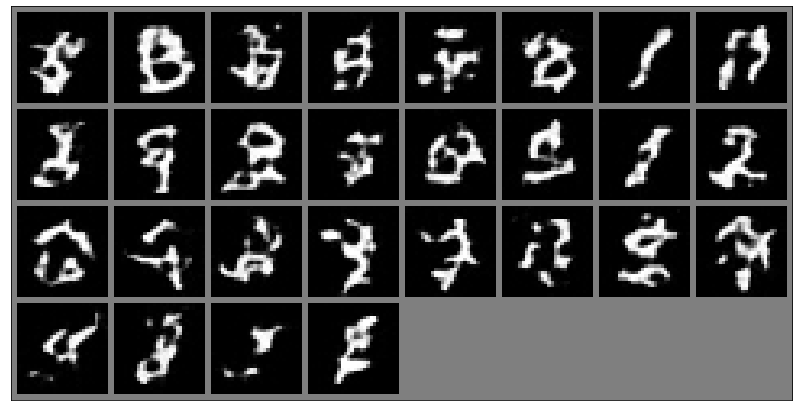

In [62]:
plt.rcParams["figure.figsize"] = (14, 10)
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

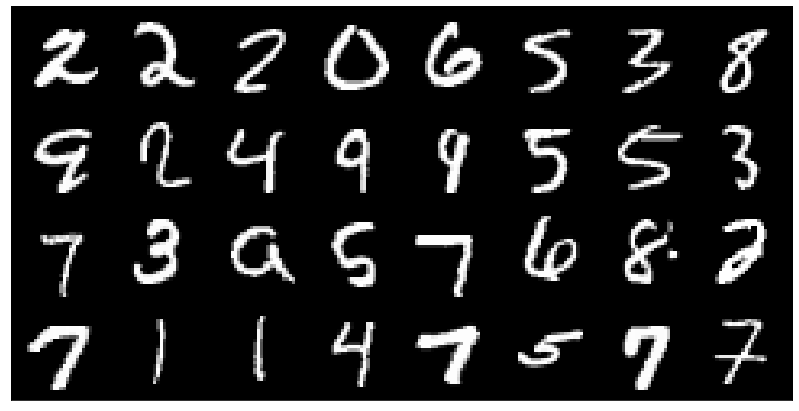

In [63]:
show(make_grid(valid_originals.cpu()+0.5)) # 正規化で+0.5

## Plot Loss

In [64]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7) # 平滑化
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

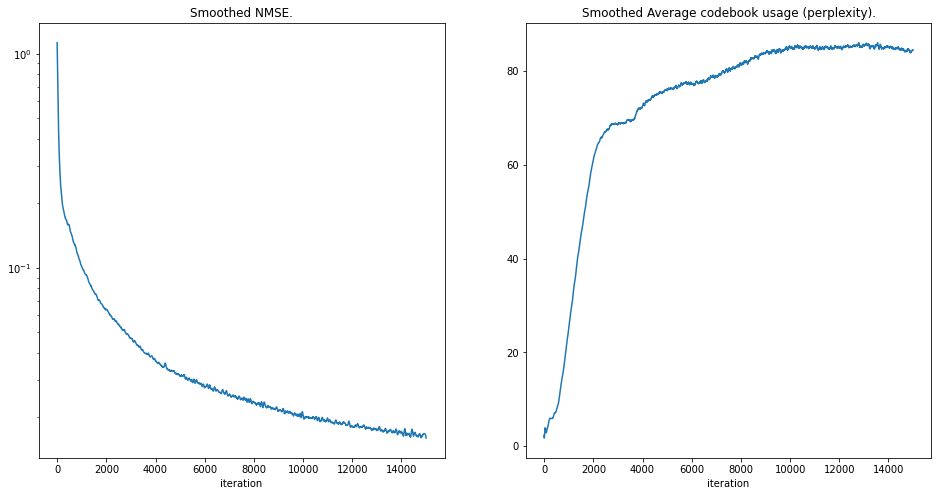

In [65]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View Embedding

In [66]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

NameError: name 'umap' is not defined

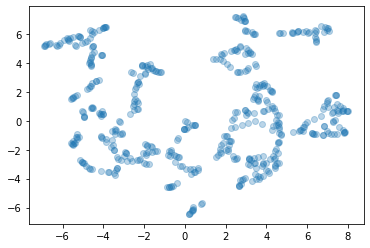

In [ ]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)